In [1]:
import pandas as pd
import json
import numpy as np
import scipy
import mturk
from collections import Counter
import pymongo
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import scipy.stats as stats
import seaborn as sns
import krippendorff_alpha as ka

In [2]:
""" Connect to the database where the results are stored """
create_hits_in_production = True

db_client = pymongo.MongoClient("mongodb+srv://<username>:<password>@cluster0-hjstc.mongodb.net/test?retryWrites=true&w=majority")
db = db_client['tbfy']

hit_result_collection = db.hit_results if create_hits_in_production else db.hit_results_sandbox

In [4]:
with open('./data/pairs_en.json','r') as f:
    pairs_en = json.load(f)
for pair in pairs_en:
    pair['pair_id'] = pair['id1']+pair['id2']
len(pairs_en)

102

In [5]:
with open('./data/banlist.json','r') as f:
    banlist = json.load(f)
len(banlist)

58

In [6]:
simple_maj = lambda x : Counter(tuple(x)).most_common()[0][0]

# Likert

In [3]:
data_likert_json = []
for hit in list(hit_result_collection.find({'scale':'likert'})):
    for ans in hit['answers']:
        for i in range(0,len(hit['documents'])):
            data_likert_json.append({
                'HITId':hit['_id'],
                'batch_id':hit['batch_id'],
                'documents_id': hit['documents_id'],
                'type': hit['type'],
                'scale': hit['scale'],
                'worker_id':ans['worker_id'],
                'document_1_id':hit['documents'][i]['document_1']['id'],
                'document_2_id':hit['documents'][i]['document_2']['id'],
                'pair_id': hit['documents'][i]['document_1']['id'] + hit['documents'][i]['document_2']['id'],
                'similarity': ans['values']['outputs'][i]['similarity'],
                'confidence': ans['values']['outputs'][i]['confidence'],
                'reason': ans['values']['outputs'][i]['reason'],
                'time': ans['values']['times'][i]
            })
print(len(data_likert_json))
data_likert_df = pd.DataFrame(data_likert_json)

KeyboardInterrupt: 

In [ ]:
data_likert_df

In [ ]:
data_likert_df_non_gd = data_likert_df[data_likert_df['pair_id'].transform(lambda x: x in [p['pair_id'] for p in pairs_en])]
data_likert_df_non_gd = data_likert_df_non_gd[data_likert_df_non_gd['worker_id'].transform(lambda x: x not in banlist)]
data_likert_df_non_gd = data_likert_df_non_gd.reset_index(drop=True)
min(data_likert_df_non_gd.groupby(['pair_id']).count().reset_index()[['pair_id','HITId']]['HITId'])

In [ ]:
data_likert_df_non_gd

In [9]:
sim_scores_df = data_likert_df_non_gd[['pair_id','similarity']]
for pair in pairs_en:
    scores = list(sim_scores_df[sim_scores_df['pair_id'] == pair['id1']+pair['id2']]['similarity'])
    value, count = Counter(scores).most_common()[0]
    pair['similarity_crowd_simple_maj'] = value
    pair['similarity_crowd_simple_mean'] = np.mean(scores)
    pair['similarity_crowd_simple_median'] = np.median(scores)
    
similarity_scores = ['none','low','medium','high']
similarity_alg = data_likert_df_non_gd['pair_id'].transform(
    lambda x : [similarity_scores.index(p['similarity'].lower()) for p in pairs_en if x == (p['id1']+p['id2'])][0]
)
similarity_crowd_simple_maj =  data_likert_df_non_gd['pair_id'].transform(
    lambda x : [p['similarity_crowd_simple_maj'] for p in pairs_en if x == (p['id1']+p['id2'])][0]
)
similarity_crowd_simple_mean =  data_likert_df_non_gd['pair_id'].transform(
    lambda x : [p['similarity_crowd_simple_mean'] for p in pairs_en if x == (p['id1']+p['id2'])][0]
)
similarity_crowd_simple_median =  data_likert_df_non_gd['pair_id'].transform(
    lambda x : [p['similarity_crowd_simple_median'] for p in pairs_en if x == (p['id1']+p['id2'])][0]
)
relations = data_likert_df_non_gd['pair_id'].transform(
    lambda x : [p['relation'] for p in pairs_en if x == (p['id1']+p['id2'])][0]
)
data_likert_df_non_gd['similarity_alg'] = similarity_alg
data_likert_df_non_gd['similarity_crowd_simple_maj'] = similarity_crowd_simple_maj
data_likert_df_non_gd['similarity_crowd_simple_mean'] = similarity_crowd_simple_mean
data_likert_df_non_gd['similarity_crowd_simple_median'] = similarity_crowd_simple_median
data_likert_df_non_gd['relation'] = relations
data_likert_df_non_gd['reason_len'] = data_likert_df_non_gd['reason'].apply(len)

In [99]:
final_scores_likert = data_likert_df_non_gd[['pair_id','similarity_alg','relation','similarity_crowd_simple_maj','similarity_crowd_simple_mean','similarity_crowd_simple_median']].drop_duplicates().reset_index(drop=True)
final_scores_likert = final_scores_likert.sort_values('pair_id').reset_index(drop=True)
final_scores_likert.to_csv('./data/final_scores_likert.csv')

## Time histograms

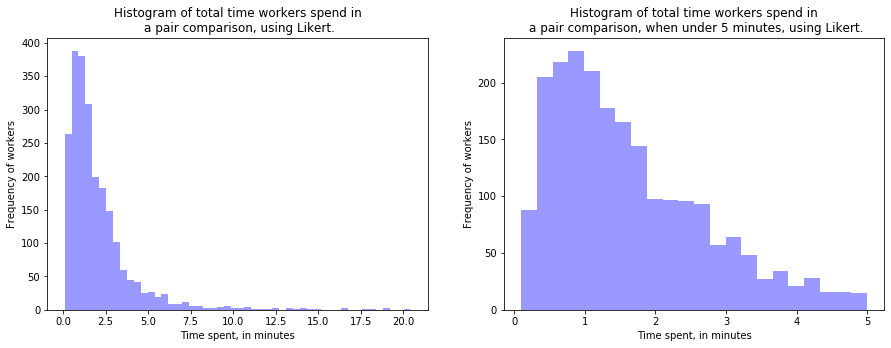

In [23]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
axes[0].set_title('Histogram of total time workers spend in\n a pair comparison, using Likert.')
axes[0].set_ylabel('Frequency of workers')
axes[1].set_title('Histogram of total time workers spend in\n a pair comparison, when under 5 minutes, using Likert.')
axes[1].set_ylabel('Frequency of workers')
sns.distplot(data_likert_df_non_gd['time'].transform(lambda x: x/60000), kde=False, color="b", ax=axes[0], axlabel='Time spent, in minutes')
sns.distplot(data_likert_df_non_gd[data_likert_df_non_gd['time']<=60000*5]['time'].transform(lambda x: x/60000), kde=False, color="b", ax=axes[1], axlabel='Time spent, in minutes')
plt.show()

## Frequency of scores

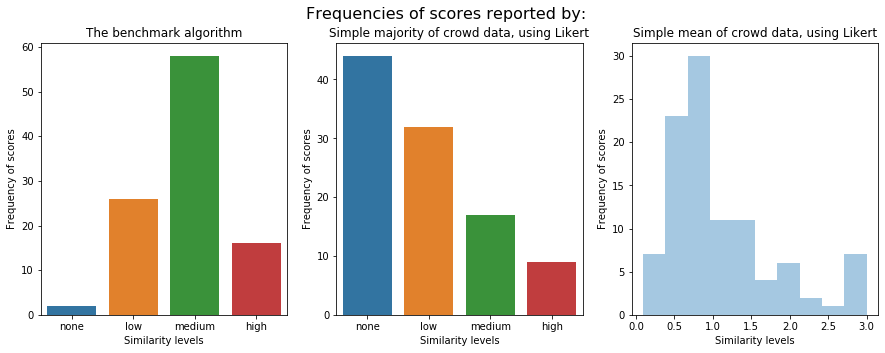

In [28]:
fig, axes = plt.subplots(1,3,figsize=(15, 5))
fig.suptitle('Frequencies of scores reported by:', fontsize=16)
axes[0].set_title('The benchmark algorithm')
axes[0].set_ylabel('Frequency of scores')
axes[0].set_xlabel('Similarity levels')
axes[1].set_title('Simple majority of crowd data, using Likert')
axes[1].set_ylabel('Frequency of scores')
axes[1].set_xlabel('Similarity levels')
axes[2].set_title('Simple mean of crowd data, using Likert')
axes[2].set_ylabel('Frequency of scores')
sim_counter_alg = Counter(final_scores_likert['similarity_alg'])
sns.barplot(x=['none','low','medium','high'],y=[sim_counter_alg[i] for i in range(4)],ax=axes[0])
similarity_crowd_simple_maj = Counter(final_scores_likert['similarity_crowd_simple_maj'])
sns.barplot(x=['none','low','medium','high'],y=[similarity_crowd_simple_maj[i] for i in range(4)],ax=axes[1])
sns.distplot(final_scores_likert['similarity_crowd_simple_mean'],ax=axes[2],kde=False, axlabel='Similarity levels')
plt.show()

## Confusion Matrices

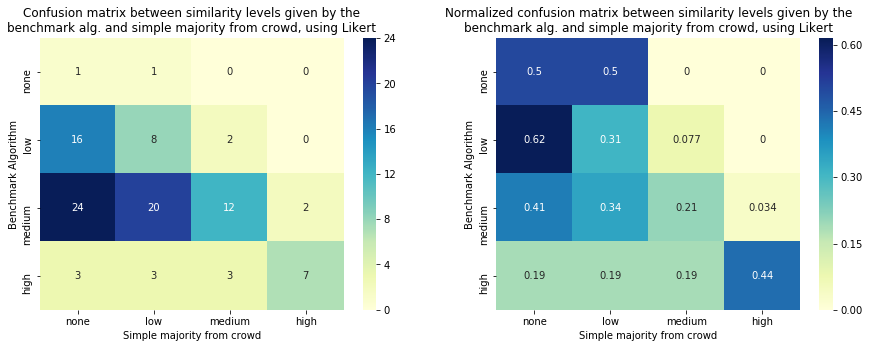

Precision: 0.43909685086155675
Recall: 0.3630222148541114
FScore: 0.29983508245877066


In [43]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
axes[0].set_title('Confusion matrix between similarity levels given by the\nbenchmark alg. and simple majority from crowd, using Likert')
axes[1].set_title('Normalized confusion matrix between similarity levels given by the\nbenchmark alg. and simple majority from crowd, using Likert')
confusion_matrix = pd.crosstab(final_scores_likert['similarity_alg'], final_scores_likert['similarity_crowd_simple_maj'], rownames=['Benchmark Algorithm'], colnames=['Simple majority from crowd'])
confusion_matrix_norm = confusion_matrix.apply(lambda x: x/sum(x), axis=1)
sns.heatmap(confusion_matrix, annot=True, ax=axes[0], xticklabels=similarity_scores, yticklabels=similarity_scores, cmap="YlGnBu")
sns.heatmap(confusion_matrix_norm, annot=True, ax=axes[1], xticklabels=similarity_scores, yticklabels=similarity_scores, cmap="YlGnBu")
plt.show()

metrics = precision_recall_fscore_support(y_true=final_scores_likert['similarity_alg'],y_pred=final_scores_likert['similarity_crowd_simple_maj'],average='macro')
print('Precision: {}\nRecall: {}\nFScore: {}'.format(metrics[0],metrics[1],metrics[2]))

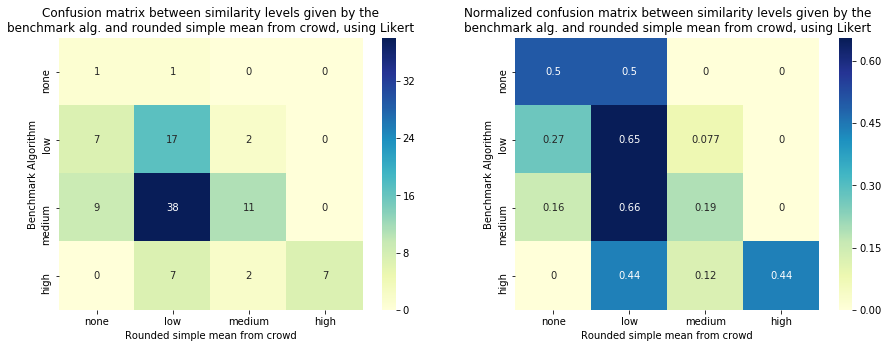

Precision: 0.5154995331465919
Recall: 0.4452503315649867
FScore: 0.34933778624811523


In [44]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
axes[0].set_title('Confusion matrix between similarity levels given by the\nbenchmark alg. and rounded simple mean from crowd, using Likert')
axes[1].set_title('Normalized confusion matrix between similarity levels given by the\nbenchmark alg. and rounded simple mean from crowd, using Likert')
confusion_matrix = pd.crosstab(final_scores_likert['similarity_alg'], final_scores_likert['similarity_crowd_simple_mean'].apply(np.round), rownames=['Benchmark Algorithm'], colnames=['Rounded simple mean from crowd'])
confusion_matrix_norm = confusion_matrix.apply(lambda x: x/sum(x), axis=1)
sns.heatmap(confusion_matrix, annot=True, ax=axes[0], xticklabels=similarity_scores, yticklabels=similarity_scores, cmap="YlGnBu")
sns.heatmap(confusion_matrix_norm, annot=True, ax=axes[1], xticklabels=similarity_scores, yticklabels=similarity_scores, cmap="YlGnBu")
plt.show()

metrics = precision_recall_fscore_support(y_true=final_scores_likert['similarity_alg'],y_pred=final_scores_likert['similarity_crowd_simple_mean'].apply(np.round),average='macro')
print('Precision: {}\nRecall: {}\nFScore: {}'.format(metrics[0],metrics[1],metrics[2]))

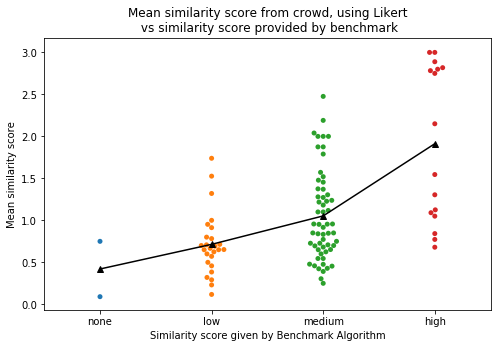

In [376]:
fig, axes = plt.subplots(1,1,figsize=(8, 5))
means_by_similarity = final_scores_likert.groupby('similarity_alg').mean()
axes.set_title('Mean similarity score from crowd, using Likert\n vs similarity score provided by benchmark')

sns.swarmplot(data=final_scores_likert,x='similarity_alg',y='similarity_crowd_simple_mean',ax=axes).\
    set(xticklabels=similarity_scores)
axes.plot([0,1,2,3],means_by_similarity['similarity_crowd_simple_mean'],'k^-',zorder=100)
axes.set(ylabel='Mean similarity score',xlabel='Similarity score given by Benchmark Algorithm')

plt.show()

## Agreement

In [36]:
golden_data_annotated = [
    [1,1,0,0,1,3,2,0,2,1,3,2,2,0,3,3,1,0,1,2], #Given by Carlos
    [0,1,0,0,0,2,2,1,3,2,2,0,1,0,2,1,2,0,2,0], #Annotated by Tom
    [3,1,0,0,2,3,3,2,3,2,2,2,2,0,3,2,2,1,1,0], #Annotateg by Guillermo
    [0,0,0,0,1,0,1,1,2,1,1,1,0,0,3,1,2,0,1,0]  #Annotated by Miya
]
print("interval metric: %.3f" % ka.krippendorff_alpha(golden_data_annotated, ka.interval_metric, missing_items='*'))

interval metric: 0.446


In [46]:
pair_worker_scores = data_likert_df_non_gd[['worker_id','pair_id','similarity']].groupby(['worker_id','pair_id']).agg(simple_maj).reset_index()
pair_worker_scores = pair_worker_scores.pivot(index='worker_id',columns='pair_id',values='similarity').fillna('*')

print("Agreement among workers: Krippendorf's alpha from Likert scale judgements using interval metric: %.3f" % ka.krippendorff_alpha(pair_worker_scores.values, ka.interval_metric, missing_items='*'))

Agreement among workers: Krippendorf's alpha from Likert scale judgements using interval metric: 0.412


## Per Relation Level

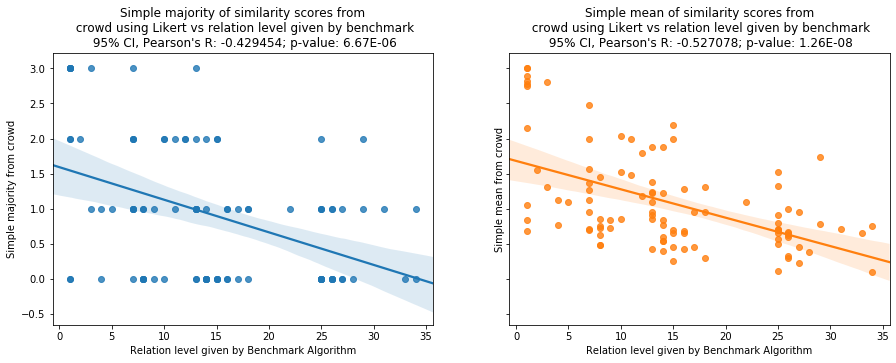

In [71]:
fig, axes = plt.subplots(1,2,figsize=(15, 5),sharey=True)

relation_scores = final_scores_likert[['similarity_crowd_simple_maj','relation']]
pearson = scipy.stats.pearsonr(relation_scores['similarity_crowd_simple_maj'],relation_scores['relation'])
axes[0].set_title('Simple majority of similarity scores from\n crowd using Likert vs relation level given by benchmark\n 95% CI, Pearson\'s R: {:6.6f}; p-value: {:.2E}'.format(
    pearson[0], pearson[1]
))
sns.regplot(data=relation_scores,y='similarity_crowd_simple_maj',x='relation',ax=axes[0])
axes[0].set(ylabel='Simple majority from crowd',xlabel='Relation level given by Benchmark Algorithm')

relation_scores = final_scores_likert[['similarity_crowd_simple_mean','relation']]
pearson = scipy.stats.pearsonr(relation_scores['similarity_crowd_simple_mean'],relation_scores['relation'])
axes[1].set_title('Simple mean of similarity scores from\n crowd using Likert vs relation level given by benchmark\n 95% CI, Pearson\'s R: {:6.6f}; p-value: {:.2E}'.format(
    pearson[0], pearson[1]
))
sns.regplot(data=relation_scores,y='similarity_crowd_simple_mean',x='relation',ax=axes[1])
axes[1].set(ylabel='Simple mean from crowd',xlabel='Relation level given by Benchmark Algorithm')


plt.show()# change labels, compute non-aggregated

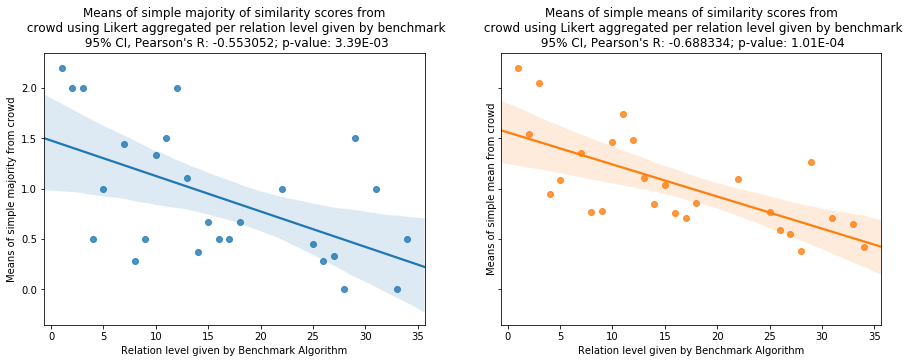

In [70]:
fig, axes = plt.subplots(1,2,figsize=(15, 5),sharey=True)

relation_scores = final_scores_likert[['similarity_crowd_simple_maj','relation']].groupby('relation').agg(np.mean).reset_index()
pearson = scipy.stats.pearsonr(relation_scores['similarity_crowd_simple_maj'],relation_scores['relation'])
axes[0].set_title('Means of simple majority of similarity scores from\n crowd using Likert aggregated per relation level given by benchmark\n 95% CI, Pearson\'s R: {:6.6f}; p-value: {:.2E}'.format(
    pearson[0], pearson[1]
))
sns.regplot(data=relation_scores,y='similarity_crowd_simple_maj',x='relation',ax=axes[0])
axes[0].set(ylabel='Means of simple majority from crowd',xlabel='Relation level given by Benchmark Algorithm')

relation_scores = final_scores_likert[['similarity_crowd_simple_mean','relation']].groupby('relation').agg(np.mean).reset_index()
pearson = scipy.stats.pearsonr(relation_scores['similarity_crowd_simple_mean'],relation_scores['relation'])
axes[1].set_title('Means of simple means of similarity scores from\n crowd using Likert aggregated per relation level given by benchmark\n 95% CI, Pearson\'s R: {:6.6f}; p-value: {:.2E}'.format(
    pearson[0], pearson[1]
))
sns.regplot(data=relation_scores,y='similarity_crowd_simple_mean',x='relation',ax=axes[1])
axes[1].set(ylabel='Means of simple mean from crowd',xlabel='Relation level given by Benchmark Algorithm')


plt.show()# change labels, compute non-aggregated

## Rank similarity

In [69]:
print("Simple majority")
print(stats.spearmanr(final_scores_likert['similarity_alg'],final_scores_likert['similarity_crowd_simple_maj']))
print(stats.kendalltau(final_scores_likert['similarity_alg'],final_scores_likert['similarity_crowd_simple_maj']))
print("\nSimple mean")
print(stats.spearmanr(final_scores_likert['similarity_alg'],final_scores_likert['similarity_crowd_simple_mean']))
print(stats.kendalltau(final_scores_likert['similarity_alg'],final_scores_likert['similarity_crowd_simple_mean']))

Simple majority
SpearmanrResult(correlation=0.38182250900117354, pvalue=7.500996643103004e-05)
KendalltauResult(correlation=0.3445376064621041, pvalue=9.164288958828359e-05)

Simple mean
SpearmanrResult(correlation=0.48978053917380837, pvalue=1.746728724591839e-07)
KendalltauResult(correlation=0.3923064459371467, pvalue=4.65644570730787e-07)


# Magnitude Estimation

In [72]:
data_magnitude_json = []
for hit in list(hit_result_collection.find({'scale':'magnitude'})):
    for ans in hit['answers']:
        for i in range(0,len(hit['documents'])):
            data_magnitude_json.append({
                'HITId':hit['_id'],
                'batch_id':hit['batch_id'],
                'documents_id': hit['documents_id'],
                'type': hit['type'],
                'scale': hit['scale'],
                'worker_id':ans['worker_id'],
                'document_1_id':hit['documents'][i]['document_1']['id'],
                'document_2_id':hit['documents'][i]['document_2']['id'],
                'pair_id': hit['documents'][i]['document_1']['id'] + hit['documents'][i]['document_2']['id'],
                'similarity': ans['values']['outputs'][i]['similarity'],
                'confidence': ans['values']['outputs'][i]['confidence'],
                'reason': ans['values']['outputs'][i]['reason'],
                'time': ans['values']['times'][i]
            })
print(len(data_magnitude_json))
data_magnitude_df = pd.DataFrame(data_magnitude_json)

5075


In [73]:
counts_per_pair = data_magnitude_df.groupby(['pair_id']).count().reset_index()[['pair_id','HITId']]
for pair in pairs_en:
    assert(int(counts_per_pair[counts_per_pair['pair_id'] == pair['pair_id']]['HITId']) >= 25)

In [74]:
data_magnitude_df = data_magnitude_df[data_magnitude_df['worker_id'].transform(lambda x: x not in banlist)]
data_magnitude_df = data_magnitude_df.reset_index(drop=True)
min(data_magnitude_df.groupby(['pair_id']).count().reset_index()[['pair_id','HITId']]['HITId'])

6

In [298]:
similarity_scores = ['none','low','medium','high']

def get_sim_score(x):
    score = [similarity_scores.index(p['similarity'].lower()) for p in pairs_en if x == (p['id1']+p['id2'])]
    if len(score)>0:
        return score[0]
    else:
        return '*'
similarity_alg = data_magnitude_df['pair_id'].transform(get_sim_score)
data_magnitude_df['similarity_alg'] = similarity_alg

def get_relation(x):
    score = [p['relation'] for p in pairs_en if x == (p['id1']+p['id2'])]
    if len(score)>0:
        return score[0]
    else:
        return '*'
relations = data_magnitude_df['pair_id'].transform(get_relation)
data_magnitude_df['relation'] = relations

data_magnitude_df['reason_len'] = data_magnitude_df['reason'].apply(len)
data_magnitude_df['log_similarity'] = data_magnitude_df['similarity'].apply(np.log)
mean_log_all = np.mean(data_magnitude_df['log_similarity'])

worker_docset_means_log = data_magnitude_df[['worker_id','documents_id','log_similarity']].groupby(['worker_id','documents_id']).mean().reset_index()
worker_docset_means_log = worker_docset_means_log.pivot(index='worker_id',columns='documents_id',values='log_similarity')
data_magnitude_df['mean_log_similarity_worker_docset'] = data_magnitude_df.apply(
    lambda x: worker_docset_means_log.loc[x['worker_id'],x['documents_id']],
    axis=1
)
worker_docset_means = data_magnitude_df[['worker_id','documents_id','similarity']].groupby(['worker_id','documents_id']).mean().reset_index()
worker_docset_means = worker_docset_means.pivot(index='worker_id',columns='documents_id',values='similarity')
data_magnitude_df['mean_similarity_worker_docset'] = data_magnitude_df.apply(
    lambda x: worker_docset_means.loc[x['worker_id'],x['documents_id']],
    axis=1
)
worker_docset_stds = data_magnitude_df[['worker_id','documents_id','similarity']].groupby(['worker_id','documents_id']).std().reset_index()
worker_docset_stds = worker_docset_stds.pivot(index='worker_id',columns='documents_id',values='similarity')
data_magnitude_df['std_similarity_worker_docset'] = data_magnitude_df.apply(
    lambda x: worker_docset_stds.loc[x['worker_id'],x['documents_id']],
    axis=1
)
worker_docset_stds_log = data_magnitude_df[['worker_id','documents_id','log_similarity']].groupby(['worker_id','documents_id']).std().reset_index()
worker_docset_stds_log = worker_docset_stds_log.pivot(index='worker_id',columns='documents_id',values='log_similarity')
data_magnitude_df['std_log_similarity_worker_docset'] = data_magnitude_df.apply(
    lambda x: worker_docset_stds_log.loc[x['worker_id'],x['documents_id']],
    axis=1
)

worker_means_log = data_magnitude_df[['worker_id','log_similarity']].groupby(['worker_id']).mean().reset_index()
worker_means_log = worker_means_log.set_index('worker_id')
data_magnitude_df['mean_log_similarity_worker'] = data_magnitude_df.apply(
    lambda x: worker_means_log.loc[x['worker_id']],
    axis=1
) 

worker_means = data_magnitude_df[['worker_id','similarity']].groupby(['worker_id']).mean().reset_index()
worker_means = worker_means.set_index('worker_id')
data_magnitude_df['mean_similarity_worker'] = data_magnitude_df.apply(
    lambda x: worker_means.loc[x['worker_id']],
    axis=1
)
worker_stds = data_magnitude_df[['worker_id','similarity']].groupby(['worker_id']).std().reset_index()
worker_stds = worker_stds.set_index('worker_id')
data_magnitude_df['std_similarity_worker'] = data_magnitude_df.apply(
    lambda x: worker_stds.loc[x['worker_id']],
    axis=1
)
worker_stds_log = data_magnitude_df[['worker_id','log_similarity']].groupby(['worker_id']).std().reset_index()
worker_stds_log = worker_stds_log.set_index('worker_id')
data_magnitude_df['std_log_similarity_worker'] = data_magnitude_df.apply(
    lambda x: worker_stds_log.loc[x['worker_id']],
    axis=1
)

hit_means_log = data_magnitude_df[['HITId','log_similarity']].groupby(['HITId']).mean().reset_index()
hit_means_log = hit_means_log.set_index('HITId')
data_magnitude_df['mean_log_similarity_hit'] = data_magnitude_df.apply(
    lambda x: hit_means_log.loc[x['HITId']],
    axis=1
)
hit_means = data_magnitude_df[['HITId','similarity']].groupby(['HITId']).mean().reset_index()
hit_means = hit_means.set_index('HITId')
data_magnitude_df['mean_similarity_hit'] = data_magnitude_df.apply(
    lambda x: hit_means.loc[x['HITId']],
    axis=1
)

data_magnitude_df['scaled_similarity_worker_docset'] = data_magnitude_df.apply(
    lambda x: np.exp((np.log(x['similarity']) - x['mean_log_similarity_worker_docset'] + mean_log_all)),
    axis=1
)
data_magnitude_df['scaled_similarity_worker'] = data_magnitude_df.apply(
    lambda x: np.exp((np.log(x['similarity']) - x['mean_log_similarity_worker'] + mean_log_all)),
    axis=1
)

data_magnitude_df_non_gd = data_magnitude_df[data_magnitude_df['pair_id'].transform(lambda x: x in [p['pair_id'] for p in pairs_en])]
final_scores_magnitude = data_magnitude_df_non_gd[['pair_id','similarity_alg','relation','scaled_similarity_worker','scaled_similarity_worker_docset']].groupby(['pair_id','similarity_alg','relation']).median().reset_index()
final_scores_magnitude = final_scores_magnitude.sort_values('pair_id').reset_index(drop=True)
final_scores_magnitude.to_csv('./data/final_scores_magnitude.csv')

## Time histograms

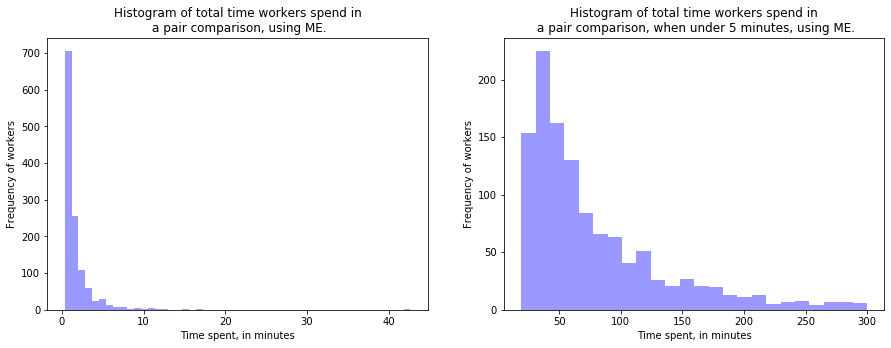

In [258]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
axes[0].set_title('Histogram of total time workers spend in\n a pair comparison, using ME.')
axes[0].set_ylabel('Frequency of workers')
axes[1].set_title('Histogram of total time workers spend in\n a pair comparison, when under 5 minutes, using ME.')
axes[1].set_ylabel('Frequency of workers')
sns.distplot(data_magnitude_df_non_gd['time'].transform(lambda x: x/60000), kde=False, color="b", ax=axes[0], axlabel='Time spent, in minutes')
sns.distplot(data_magnitude_df_non_gd[data_magnitude_df_non_gd['time']<=60000*5]['time'].transform(lambda x: x/1000), kde=False, color="b", ax=axes[1], axlabel='Time spent, in minutes')
plt.show()

## Frequency of scores

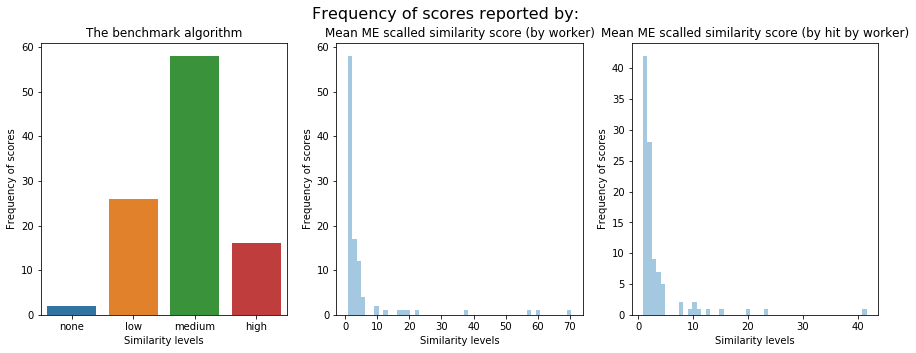

In [259]:
fig, axes = plt.subplots(1,3,figsize=(15, 5))
fig.suptitle('Frequency of scores reported by:', fontsize=16)
axes[0].set_title('The benchmark algorithm')
axes[0].set_ylabel('Frequency of scores')
axes[0].set_xlabel('Similarity levels')
axes[1].set_title('Mean ME scalled similarity score (by worker)')
axes[1].set_ylabel('Frequency of scores')
axes[1].set_xlabel('Similarity levels')
axes[2].set_title('Mean ME scalled similarity score (by hit by worker)')
axes[2].set_ylabel('Frequency of scores')
sim_counter_alg = Counter(final_scores_magnitude['similarity_alg'])
sns.barplot(x=['none','low','medium','high'],y=[sim_counter_alg[i] for i in range(4)],ax=axes[0])
sns.distplot(final_scores_magnitude['scaled_similarity_worker'],ax=axes[1],kde=False, axlabel='Similarity levels')
sns.distplot(final_scores_magnitude['scaled_similarity_worker_docset'],ax=axes[2],kde=False, axlabel='Similarity levels')
plt.show()

## Confusion Plots

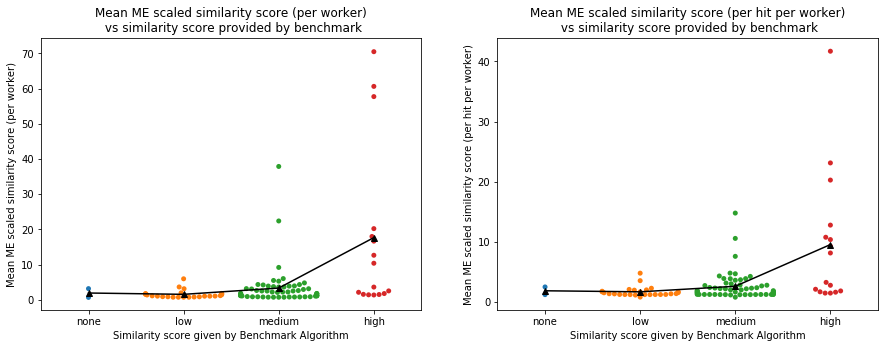

In [377]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
means_by_similarity = final_scores_magnitude.groupby('similarity_alg').mean()
axes[0].set_title('Mean ME scaled similarity score (per worker)\n vs similarity score provided by benchmark')
axes[1].set_title('Mean ME scaled similarity score (per hit per worker)\n vs similarity score provided by benchmark')

sns.swarmplot(data=final_scores_magnitude,x='similarity_alg',y='scaled_similarity_worker',ax=axes[0]).\
    set(xticklabels=similarity_scores)
axes[0].plot([0,1,2,3],means_by_similarity['scaled_similarity_worker'],'k^-',zorder=100)

sns.swarmplot(data=final_scores_magnitude,x='similarity_alg',y='scaled_similarity_worker_docset',ax=axes[1]).\
    set(xticklabels=similarity_scores)
axes[1].plot([0,1,2,3],means_by_similarity['scaled_similarity_worker_docset'],'k^-',zorder=100)

axes[0].set(ylabel='Mean ME scaled similarity score (per worker)',xlabel='Similarity score given by Benchmark Algorithm')
axes[1].set(ylabel='Mean ME scaled similarity score (per hit per worker)',xlabel='Similarity score given by Benchmark Algorithm')
plt.show()

## Agreement

In [368]:
pair_worker_scores = data_magnitude_df_non_gd[['worker_id','pair_id','scaled_similarity_worker']].groupby(['worker_id','pair_id']).agg(np.mean).reset_index()
pair_worker_scores = pair_worker_scores.pivot(index='worker_id',columns='pair_id',values='scaled_similarity_worker').fillna('*')

print("Per worker ratio metric: %.3f" % ka.krippendorff_alpha(pair_worker_scores.values, ka.ratio_metric, missing_items='*'))

pair_worker_scores = data_magnitude_df_non_gd[['worker_id','pair_id','scaled_similarity_worker_docset']].groupby(['worker_id','pair_id']).agg(np.mean).reset_index()
pair_worker_scores = pair_worker_scores.pivot(index='worker_id',columns='pair_id',values='scaled_similarity_worker_docset').fillna('*')

print("Per worker per hit ratio metric: %.3f" % ka.krippendorff_alpha(pair_worker_scores.values, ka.ratio_metric, missing_items='*'))

Per worker ratio metric: 0.189
Per worker per hit ratio metric: 0.183


## Per Relation Level

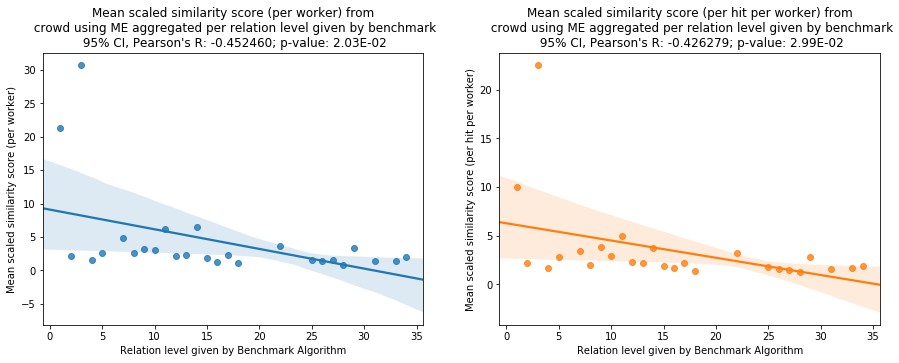

In [378]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))

relation_scores = final_scores_magnitude[['scaled_similarity_worker','relation']].groupby('relation').agg(np.mean).reset_index()
pearson = scipy.stats.pearsonr(relation_scores['scaled_similarity_worker'],relation_scores['relation'])
axes[0].set_title('Mean scaled similarity score (per worker) from\n crowd using ME aggregated per relation level given by benchmark\n 95% CI, Pearson\'s R: {:6.6f}; p-value: {:.2E}'.format(
    pearson[0], pearson[1]
))
sns.regplot(data=relation_scores,y='scaled_similarity_worker',x='relation',ax=axes[0])
axes[0].set(ylabel='Mean scaled similarity score (per worker)',xlabel='Relation level given by Benchmark Algorithm')

relation_scores = final_scores_magnitude[['scaled_similarity_worker_docset','relation']].groupby('relation').agg(np.mean).reset_index()
pearson = scipy.stats.pearsonr(relation_scores['scaled_similarity_worker_docset'],relation_scores['relation'])
axes[1].set_title('Mean scaled similarity score (per hit per worker) from\n crowd using ME aggregated per relation level given by benchmark\n 95% CI, Pearson\'s R: {:6.6f}; p-value: {:.2E}'.format(
    pearson[0], pearson[1]
))
sns.regplot(data=relation_scores,y='scaled_similarity_worker_docset',x='relation',ax=axes[1])
axes[1].set(ylabel='Mean scaled similarity score (per hit per worker)',xlabel='Relation level given by Benchmark Algorithm')

plt.show()

## Rank similarity

In [263]:
print("Scaled similarity per worker per hit")
print(stats.spearmanr(final_scores_magnitude['similarity_alg'],final_scores_magnitude['scaled_similarity_worker_docset']))
print(stats.kendalltau(final_scores_magnitude['similarity_alg'],final_scores_magnitude['scaled_similarity_worker_docset']))
print("\nScaled similarity per worker")
print(stats.spearmanr(final_scores_magnitude['similarity_alg'],final_scores_magnitude['scaled_similarity_worker']))
print(stats.kendalltau(final_scores_magnitude['similarity_alg'],final_scores_magnitude['scaled_similarity_worker']))

Scaled similarity per worker per hit
SpearmanrResult(correlation=0.4154001106694067, pvalue=1.4151785355857267e-05)
KendalltauResult(correlation=0.3317961037625381, pvalue=2.1440342995477118e-05)

Scaled similarity per worker
SpearmanrResult(correlation=0.41640395081502135, pvalue=1.3425702346668215e-05)
KendalltauResult(correlation=0.333530813604504, pvalue=1.9151840222782535e-05)


# Ranking tasks

In [309]:
data_ranking_json = []
for hit in list(hit_result_collection.find({'type':'ranking'})):
    for ans in hit['answers']:
        for i in range(0,len(hit['documents'])):
            for j in range(0,len(hit['documents'][i]['documents'])):
                data_ranking_json.append({
                    'HITId':hit['_id'],
                    'batch_id':hit['batch_id'],
                    'documents_id': hit['documents_id'],
                    'type': hit['type'],
                    'scale': hit['scale'],
                    'worker_id':ans['worker_id'],
                    'document_1_id':hit['documents'][i]['main_document']['id'],
                    'document_2_id':hit['documents'][i]['documents'][j]['id'],
                    'pair_id': hit['documents'][i]['main_document']['id'] + hit['documents'][i]['documents'][j]['id'],
                    'similarity': ans['values']['outputs'][i]['similarity'][j],
                    'confidence': ans['values']['outputs'][i]['confidence'],
                    'reason': ans['values']['outputs'][i]['reason'],
                    'time': ans['values']['times'][i]
                })
print(len(data_ranking_json))
data_ranking_df = pd.DataFrame(data_ranking_json)

3420


In [322]:
similarity_scores = ['none','low','medium','high']

def get_sim_score(x):
    score = [similarity_scores.index(p['similarity'].lower()) for p in pairs_en if x == (p['id1']+p['id2'])]
    if len(score)>0:
        return score[0]
    else:
        return '*'
similarity_alg = data_ranking_df['pair_id'].transform(get_sim_score)
data_ranking_df['similarity_alg'] = similarity_alg

def get_relation(x):
    score = [p['relation'] for p in pairs_en if x == (p['id1']+p['id2'])]
    if len(score)>0:
        return score[0]
    else:
        return '*'
relations = data_ranking_df['pair_id'].transform(get_relation)
data_ranking_df['relation'] = relations

data_ranking_df['reason_len'] = data_ranking_df['reason'].apply(len)

mean_rankings = data_ranking_df[['pair_id','similarity']].groupby('pair_id').mean().reset_index()
mean_rankings = mean_rankings.set_index('pair_id')
data_ranking_df['mean_similarity'] = data_ranking_df.apply(
    lambda x: mean_rankings.loc[x['pair_id']],
    axis=1
)

data_ranking_df_non_gd = data_ranking_df[data_ranking_df['pair_id'].transform(lambda x: x in [p['pair_id'] for p in pairs_en])]
data_ranking_df_non_gd = data_ranking_df_non_gd[data_ranking_df_non_gd['worker_id'].transform(lambda x: x not in banlist)]
data_ranking_df_non_gd = data_ranking_df_non_gd.reset_index(drop=True)
min(data_ranking_df_non_gd.groupby(['pair_id']).count().reset_index()[['pair_id','HITId']]['HITId'])

25

In [336]:
final_scores_ranking = data_ranking_df_non_gd[['pair_id','similarity_alg','relation','mean_similarity']].groupby(['pair_id','similarity_alg','relation']).mean().reset_index()
final_scores_ranking = final_scores_ranking.sort_values('pair_id').reset_index(drop=True)
final_scores_ranking.to_csv('./data/final_scores_ranking.csv')

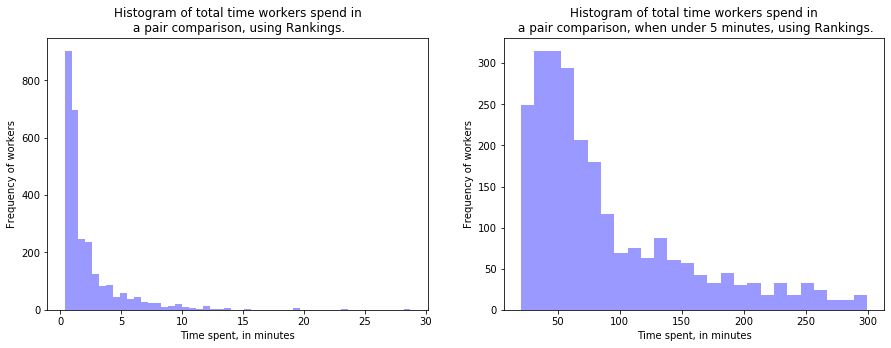

In [335]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
axes[0].set_title('Histogram of total time workers spend in\n a pair comparison, using Rankings.')
axes[0].set_ylabel('Frequency of workers')
axes[1].set_title('Histogram of total time workers spend in\n a pair comparison, when under 5 minutes, using Rankings.')
axes[1].set_ylabel('Frequency of workers')
sns.distplot(data_ranking_df_non_gd['time'].transform(lambda x: x/60000), kde=False, color="b", ax=axes[0], axlabel='Time spent, in minutes')
sns.distplot(data_ranking_df_non_gd[data_ranking_df_non_gd['time']<=60000*5]['time'].transform(lambda x: x/1000), kde=False, color="b", ax=axes[1], axlabel='Time spent, in minutes')
plt.show()

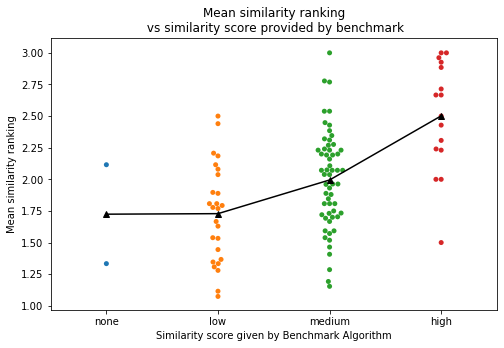

In [342]:
fig, axes = plt.subplots(1,1,figsize=(8, 5))
means_by_similarity = final_scores_ranking.groupby('similarity_alg').mean()
axes.set_title('Mean similarity ranking\n vs similarity score provided by benchmark')

sns.swarmplot(data=final_scores_ranking,x='similarity_alg',y='mean_similarity',ax=axes).\
    set(xticklabels=similarity_scores)
axes.plot([0,1,2,3],means_by_similarity['mean_similarity'],'k^-',zorder=100)
axes.set(ylabel='Mean similarity ranking',xlabel='Similarity score given by Benchmark Algorithm')

plt.show()

In [341]:
pair_worker_scores = data_ranking_df_non_gd[['worker_id','pair_id','similarity']].groupby(['worker_id','pair_id']).agg(np.mean).reset_index()
pair_worker_scores = pair_worker_scores.pivot(index='worker_id',columns='pair_id',values='similarity').fillna('*')

print("Per worker interval metric: %.3f" % ka.krippendorff_alpha(pair_worker_scores.values, ka.interval_metric, missing_items='*'))

Per worker interval metric: 0.343


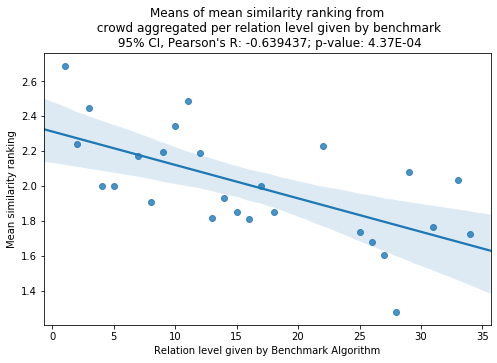

In [347]:
fig, axes = plt.subplots(1,1,figsize=(8, 5))

relation_scores = final_scores_ranking[['mean_similarity','relation']].groupby('relation').agg(np.mean).reset_index()
pearson = scipy.stats.pearsonr(relation_scores['mean_similarity'],relation_scores['relation'])
axes.set_title('Means of mean similarity ranking from\n crowd aggregated per relation level given by benchmark\n 95% CI, Pearson\'s R: {:6.6f}; p-value: {:.2E}'.format(
    pearson[0], pearson[1]
))
sns.regplot(data=relation_scores,y='mean_similarity',x='relation',ax=axes)
axes.set(ylabel='Mean similarity ranking',xlabel='Relation level given by Benchmark Algorithm')

plt.show()

In [349]:
print("Mean ranking similarity")
print(stats.spearmanr(final_scores_ranking['similarity_alg'],final_scores_ranking['mean_similarity']))
print(stats.kendalltau(final_scores_ranking['similarity_alg'],final_scores_ranking['mean_similarity']))

Mean ranking similarity
SpearmanrResult(correlation=0.48011662922553, pvalue=3.2838128800379354e-07)
KendalltauResult(correlation=0.3879323976110067, pvalue=6.507135227962557e-07)


# Ranking similarity comparison between models

In [379]:
final_scores_all = [
    final_scores_likert['similarity_alg'],
    final_scores_likert['similarity_crowd_simple_maj'],
    final_scores_likert['similarity_crowd_simple_mean'],
    final_scores_magnitude['scaled_similarity_worker_docset'],
    #final_scores_magnitude['scaled_similarity_worker'],
    final_scores_ranking['mean_similarity']
]
final_scores_all_labels = [
    'Algorithm',
    'Likert simple maj',
    'Likert mean',
    'Magnitude scaled worker hit',
    #'Magnitude scaled worker',
    'Ranking mean ranking similarity'
]

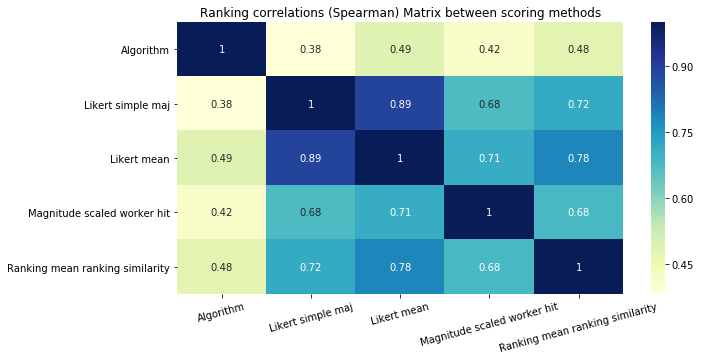

In [385]:
fig, axes = plt.subplots(1,1,figsize=(10, 5))
axes.set_title('Ranking correlations (Spearman) Matrix between scoring methods')
spearmanr_matrix = np.empty(shape=(len(final_scores_all),len(final_scores_all)))
for i in range(len(final_scores_all)):
    for j in range(len(final_scores_all)):
        spearmanr_matrix[i][j] = stats.spearmanr(final_scores_all[i],final_scores_all[j])[0]
sns.heatmap(spearmanr_matrix, annot=True,cmap="YlGnBu",ax=axes,xticklabels=final_scores_all_labels,yticklabels=final_scores_all_labels)
plt.xticks(rotation=15)
plt.savefig('spearman.jpg')
plt.show()

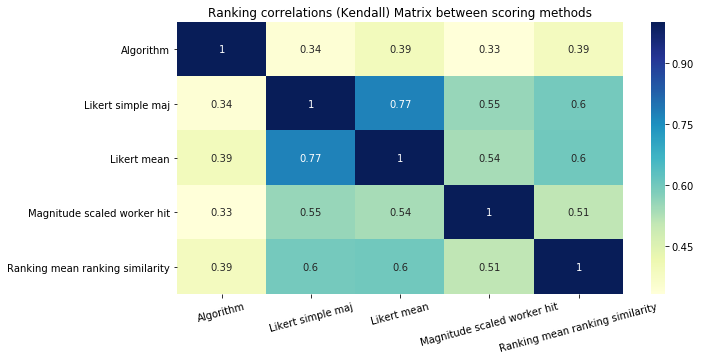

In [381]:
fig, axes = plt.subplots(1,1,figsize=(10, 5))
axes.set_title('Ranking correlations (Kendall) Matrix between scoring methods')        
kendall_matrix = np.empty(shape=(len(final_scores_all),len(final_scores_all)))
for i in range(len(final_scores_all)):
    for j in range(len(final_scores_all)):
        kendall_matrix[i][j] = stats.kendalltau(final_scores_all[i],final_scores_all[j])[0]
sns.heatmap(kendall_matrix, annot=True,cmap="YlGnBu",ax=axes,xticklabels=final_scores_all_labels,yticklabels=final_scores_all_labels)
plt.xticks(rotation=15) 
plt.show()